Some interesting questions that can be answered using this dataset are:

1. Which apps are most reviewed? Of those, which ones have the highest rating, let's say, the top three?

2. How do these apps vary by rating, pricing, and the ratio of reviews based on number of installs?

3. Do people see paid apps in the same way they see free apps? 


### Dataset Context

The applications -or *apps*- offered in the Google Play store are in the millions and growing. As of the writing of this project, the Google Play store is estimated to hold 2.6 million applications. The creator of this dataset, Lavanya Gupta, was able to obtain data on 10,000 of these apps.

She obtained the dataset through scraping the store, which uses dynamic page loading. Dynamic page loading means that the store page displays the apps based on what Google knows about the user requesting the page. And scraping means that she wrote a script that runs through the dynamically-loaded page, reads the data, and outputs it into a structured file, such as the csv file I will be working with for this project.

The data files include another file containing a sentiment analysis conducted on this sample of Google Play apps using the nltk Python library, which stands for Natural Language Toolkit. The objective of this analysis is to try to understand user reviews and what they convey about their opinions of these apps. 

### Dataset Content

#### A. googleplaystore.csv

This file contains the main dataset. It has 10,841 rows of data with the following columns:

*App Category*: Category of the app. This could be beauty, business, entertainment, education...etc.

*Rating*: How users rate the app out of 5, with 1 being the lowest rating and 5 being the highest.

*Reviews*: The number of user reviews each app has received.

*Size*: The memory size needed to install the application.

*Installs*: The number of times each application has been installed by users.

*Type*: Whether the app is free or a paid app.

*Price*: The price of the app.

*Content Rating*: This column specifies the intended audience for the app. Can be for teens, mature audience, or everyone.

*Genres*: The sub-category for each app. Example: for the Education category, this could be Education: Pretend Play.

*Last Updated*: Release date of the most recent update for the app.

*Current Ver*: The app's current version.

*Android Ver*: The oldest version of Android OS supported by the app.


#### B. googleplaystore_user_reviews.csv

This file contains the result of the sentiment analysis conducted by the dataset creator. It has 64,295 rows of data with the following columns:

*App* : Name of the app.

*Translated_Review*: Either the original review in English, or a translated version if the orignal review is in another language.

*Sentiment*: The result of the sentiment analysis conducted on a review. The value is either Positive, Neutral, or Negative.

*Sentiment_Polarity*: A value indicating the positivity or negativity of the sentiment, values range from -1 (most negative) to 1 (most positive).

*Sentiment_Subjectivity*: A value from 0 to 1 indicating the subjectivity of the review. Lower values indicate the review is based on factual information, and higher values indicate the review is based on personal or public opinions or judgements.

### Summary of Limitations

The limitations of the Google Play Store Apps data are:

1. The apps included are relevant to the dataset creator's activity on Google-related sites. She is a Machine Learning Software Developer based in India. It is most likely the applications generated are based on their popularity in the geographical region around India, while this analysis is intended for audience in the U.S or North America.


2. With cloud-based storage available for Android users at little or no cost, app size may have no significant contribution to app popularity. Therefore the *Size* column will be removed.


3. I am not sure if apps follow the same software versioning process, therefore I will assume the *Current Ver* column will be irrelevant to this analysis. Otherwise it would have been useful for measuring current support of the app by its developers.


4. I will assume that the vast majority of users can upgrade their Android devices to the latest version. Based on that, the *Android Ver* column will also be excluded. Any limitations that may justify relying on older versions of Android most probably do not apply to the majority of the population.


5. Scraping data off of a Google website is an unconventional way to obtain it, which may result in misplaced data. This largely depends on the scraper built by the dataset creator.


6. The sentiment analysis result is limited by the abilities of Python's nltk library, which does not support all languages. Reviews with unsupported languages will not be translated and should have no values within the analysis output.

I will start by importing the csv files into two Pandas dataframes, one called *app_data* which contains the main data on the applications, and another called *sentiment_data* containing the sentiment analysis results on app reviews.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import warnings


%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
#Import the googleplaystore.csv into a Pandas dataframe
app_data = pd.read_csv("..\google-play-store-apps\googleplaystore.csv")

#Show the first 3 rows of the dataframe
app_data.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


With over 10,000 rows of data being obtained through a scraper, and rating and reviews being non-mandatory for users, we can expect some missing data in our columns. Let's construct a clear picture of what how many missing values we have in each column:

In [5]:
#header
print ("Missing Values"+"\n"+"-"*15+"\n")

#Iterate over columns and calculate the sum of missing for each column
for column in app_data.columns:
    missing_vals = app_data[column].isna().sum()
    percentage = round(missing_vals/len(app_data)*100,0)
    percentage = str(percentage)+"%"
    print (column+": "+ str(missing_vals)+" <"+"-"*6+percentage + " of total.")

Missing Values
---------------

App: 0 <------0.0% of total.
Category: 0 <------0.0% of total.
Rating: 1474 <------14.0% of total.
Reviews: 0 <------0.0% of total.
Size: 0 <------0.0% of total.
Installs: 0 <------0.0% of total.
Type: 1 <------0.0% of total.
Price: 0 <------0.0% of total.
Content Rating: 1 <------0.0% of total.
Genres: 0 <------0.0% of total.
Last Updated: 0 <------0.0% of total.
Current Ver: 8 <------0.0% of total.
Android Ver: 3 <------0.0% of total.


Except for the *Rating* column values, I would say we have a good dataset. Since answering our first question relies on having user-generated ratings rather than a mean we can calculate to substitute for missing values, these rows will be removed from the dataset.

Now, the rows are in their original sorting order. While the most popular apps are would still be most popular according to India and Lavanya's user behavior, I am confident they are still recognizable by North American audience due to their global offering, let's take a look at the most installed apps within this dataset:

In [6]:
# Sort the original dataset by number of installs to see most popular apps first
app_data = app_data.sort_values(by="Installs", ascending=False)
app_data.head(4)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN
420,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17714850,40M,"500,000,000+",Free,0,Teen,Communication,"August 2, 2018",12.8.5.1121,4.0 and up
474,LINE: Free Calls & Messages,COMMUNICATION,4.2,10790289,Varies with device,"500,000,000+",Free,0,Everyone,Communication,"July 26, 2018",Varies with device,Varies with device
3767,Flipboard: News For Our Time,NEWS_AND_MAGAZINES,4.4,1284017,Varies with device,"500,000,000+",Free,0,Everyone 10+,News & Magazines,"August 3, 2018",Varies with device,Varies with device


*Life Made WI-Fi Touchscreen Photo Frame* is listed in the top, but is not a result of a huge amount of installs. This is probably due to an error in data entry that is attributed to the scraper used to get this dataset. However it is good that only one erroneous row exists beyond the true most-installed app rows. Since erroneous rows are likely to exist outside the range of [0, maximum value], it is a must to check if such rows exist beyond rows with 0 installs as well:

In [7]:
#re-sort the data in ascending order to show least installed apps first
app_data = app_data.sort_values(by="Installs")
app_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device
9337,EG | Explore Folegandros,TRAVEL_AND_LOCAL,NaN,0,56M,0+,Paid,$3.99,Everyone,Travel & Local,"January 22, 2017",1.1.1,4.1 and up
9719,EP Cook Book,MEDICAL,NaN,0,3.2M,0+,Paid,$200.00,Everyone,Medical,"July 26, 2015",1.0,3.0 and up
6692,cronometra-br,PRODUCTIVITY,NaN,0,5.4M,0+,Paid,$154.99,Everyone,Productivity,"November 24, 2017",1.0.0,4.1 and up
8081,CX Network,BUSINESS,NaN,0,10M,0+,Free,0,Everyone,Business,"August 6, 2018",1.3.1,4.1 and up


This is good news, no erroneous rows exist below 0 for the *Installs* column. Therefore all we have to do is delete
that one erroneous row. So far now we will delete:

**Rows:**
1. That erroneous row, with an index number of **10472**
2. All rows with missing -*NaN*- values in the *Rating* column.

**Columns:**
1. *Size*
2. *Current Ver*
3. *Andoird Ver*

In [8]:
#get indexes of rows with NaN values for Rating column
nan_rows = list(app_data[app_data["Rating"].isna()].index)
#add the index of the erroneous row
nan_rows.append(10472)

#remove all rows with missing values
app_data = app_data.drop(nan_rows, axis=0)

#remove unusable columns
app_data = app_data.drop(columns=["Size", "Current Ver","Android Ver"])

#re-sort the data in descending order
app_data = app_data.sort_values(by="Installs", ascending=False)

app_data.head()

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated
342,Viber Messenger,COMMUNICATION,4.3,11334799,"500,000,000+",Free,0,Everyone,Communication,"July 18, 2018"
3703,MX Player,VIDEO_PLAYERS,4.5,6474426,"500,000,000+",Free,0,Everyone,Video Players & Editors,"August 6, 2018"
420,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17714850,"500,000,000+",Free,0,Teen,Communication,"August 2, 2018"
474,LINE: Free Calls & Messages,COMMUNICATION,4.2,10790289,"500,000,000+",Free,0,Everyone,Communication,"July 26, 2018"
3574,Cloud Print,PRODUCTIVITY,4.1,282460,"500,000,000+",Free,0,Everyone,Productivity,"May 23, 2018"


Having done initial cleaning of data, now we proceed to answer the first question in this document:









## 1. Which apps are most reviewed? Of those, which ones have the highest rating, let's say the top 10?

To proceed in answering the first part of our first question *What apps are most reviewed?*, it is logical to assume the most installed apps have the most reviews. As mentioned above, the number of installs for each application is not an actual number, but a group or level of installs this app has reached (example: 50 million and up). Therefore we will call them **bins** throughout this document. Let's plot these bins of *Installs* that we have in our dataset:

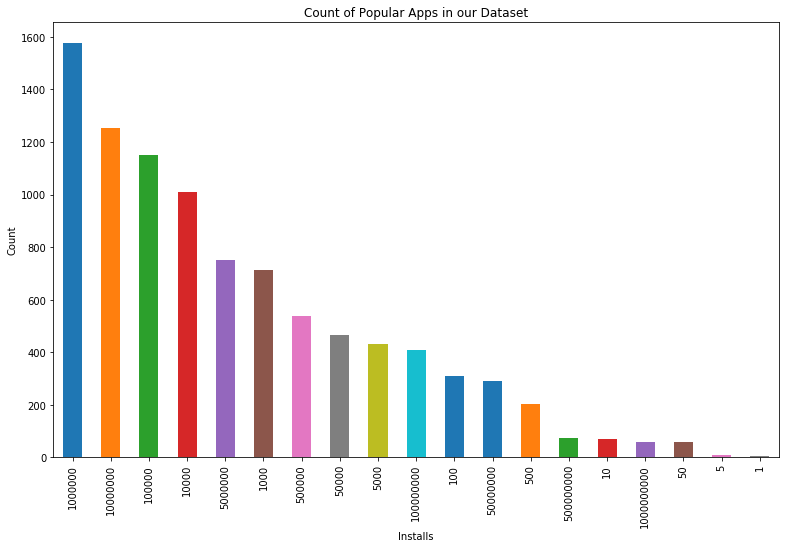

In [58]:
#Generate a series containing count of apps with each bin of number of installs

#Plot each bin of installs with its frequency/occurrence/count in the dataset
plt.figure(figsize=(13,8))
app_data["Installs"].value_counts().plot(kind='bar')
plt.title("Count of Popular Apps in our Dataset")
plt.ylabel("Count")
plt.xlabel("Installs")
plt.show()

Most apps in our dataset have been installed over a million times, and over 10 million times resepectively. It only makes sense to compare apps that are in the same bin to each other in terms of reviews and ratings. However, this leaves us with about 20 bins, with many of these apps not being necessarily that popular. To get a better focus on popular apps, I will choose the top 10 bins for this analysis. Which bins are in the top 10?

In [10]:
top_10 = np.unique(app_data["Installs"])

top_10 = sorted(top_10,key=len,reverse=True)
top_10 = top_10[:10]
print(top_10)
del top_10

['1,000,000,000+', '100,000,000+', '500,000,000+', '10,000,000+', '50,000,000+', '1,000,000+', '5,000,000+', '100,000+', '500,000+', '10,000+']


The least known apps in our list of top 10 bins seem to be the ones with more than 10,000 installs. However, the sorting order is according to the length (len) and then it would be according to the string characters, which is why we see the 100 million+ value coming before the 500 million+. Since we have sliced the list to contain only the top 10, we can see that the last value is 10,000+, where it should be 50,000+. This will be easier to deal with after parsing those values to integers.

For now, anything below 50,000 installs will be removed from consideration in answering our first question. The next step is to parse column bins into integer numbers so we can select rows with only those bins in a [Pythonic way](https://www.quora.com/What-is-the-Pythonic-way):

In [11]:
integerized = []
for value in app_data["Installs"]:

    #Remove the + sign from end of value
    value = value.replace("+","")

    #Remove the commas used as thousand-separators, then parse the number to integer
    value = int(value.replace(",",""))

    #add the integer value to the integerized list
    integerized.append(value)

#replace the installs column with the new integer values
app_data["Installs"] = [value for value in pd.Series(integerized)]

del integerized

Now to the final step in finalizing a dataframe that has the necessary data to answer the first question, selecting rows that belong in the top 10 bins:

In [12]:
# A new dataframe containing rows in top 10 bins
top_10_df = app_data[app_data["Installs"] >= 50000]

# How much does this data represent of the original data?
print (str(round(len(top_10_df)/len(app_data)*100,0))+"%")

70.0%


Now to see the most reviewed apps. Apps in each bin will be compared based on the ratio of number of reviews to number of installs, which I will call *Review Ratio*, calculated using the formula: 

$$Review Ratio = \frac {Reviews}{Installs}$$

The *Review* column data type is still string, therefore it will be converted to integer first.

In [13]:
# Parse review column values to integers
top_10_df["Reviews"] = [int(value) for value in top_10_df["Reviews"]]

# add a new column containing review ratios
top_10_df["ReviewRatio"] = top_10_df["Reviews"]/top_10_df["Installs"]

## maybe because of indexing

Let's take a look at how the review ratios look for our top 10 bins. For each bin, we will take the app with the highest *ReviewRatio*:

In [14]:
# A dataframe to contain the most reviewed app from each bin:
most_reviewed = pd.DataFrame()

# Get the most reviewed app from each bin and add it to the most_reviewed dataframe
for bins in np.unique(top_10_df["Installs"]):
    top_row = top_10_df[top_10_df["Installs"]==bins]
    top_row = top_row.sort_values(by="ReviewRatio", ascending=False)
    top_row = top_row.head(1)
    most_reviewed = most_reviewed.append(top_row)

most_reviewed = most_reviewed.drop(columns=["Category","Type","Price","Content Rating","Genres","Last Updated"])
most_reviewed

,App,Rating,Reviews,Installs,ReviewRatio
6181,Shadow Fight 2 Special Edition,4.5,10440,50000,0.208800
9627,ai.type keyboard Plus + Emoji,4.5,57076,100000,0.570760
7766,CR & CoC Private Server - Clash Barbarians PRO,4.6,167974,500000,0.335948
10809,Castle Clash: RPG War and Strategy FR,4.7,376223,1000000,0.376223
4242,"Fame Boom for Real Followers, Likes",4.7,896118,5000000,0.179224
1888,Homescapes,4.6,3093932,10000000,0.309393
6551,Boom Beach,4.5,5591653,50000000,0.111833
1879,Clash of Clans,4.6,44893888,100000000,0.448939
4005,Clean Master- Space Cleaner & Antivirus,4.7,42916526,500000000,0.085833
2544,Facebook,4.1,78158306,1000000000,0.078158


And there it is! The most reviewed app from each bin of installs. Being the most reviewed does not mean the highest rated, as in the Facebook app's case, but it certainly gives more credibility to the rating. 

Now to the second part of our question, what are the top 3 rated apps from these top 10?

In [15]:
highest_rated = most_reviewed.sort_values(by="Rating", ascending=False).head(3)
highest_rated

,App,Rating,Reviews,Installs,ReviewRatio
10809,Castle Clash: RPG War and Strategy FR,4.7,376223,1000000,0.376223
4242,"Fame Boom for Real Followers, Likes",4.7,896118,5000000,0.179224
4005,Clean Master- Space Cleaner & Antivirus,4.7,42916526,500000000,0.085833


In terms of rating, the top 3 apps tie on 4.7 out of 5.0! 

## 2. How do these apps vary by rating, pricing, and the ratio of reviews based on number of installs? 

### A. Rating

We have seen that apps with the highest review ratios for the top 10 bins had maximum ratings of 4.7 out of 5, and a minimum of 4.1, but that is only for apps with the highest review ratios.

What about other apps in the top 10 bins? To have a clearer idea, let's plot the rating column from our dataset:

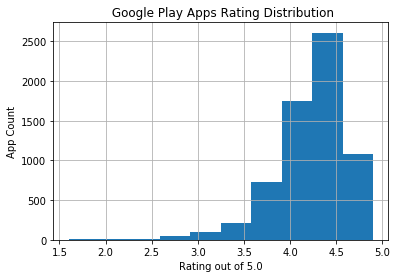

In [16]:
top_10_df["Rating"].hist()
plt.title(" Google Play Apps Rating Distribution")
plt.ylabel("App Count")
plt.xlabel("Rating out of 5.0")
plt.show()

Over 2500 of the apps in the top 10 bins have a rating of over 4.2 to a nudge over 4.5, maybe 4.6. And almost 1000 apps have been rated higher than that. To get our numbers right, let's see a quick descriptive summary of ratings:

In [17]:
top_10_df["Rating"].describe()

count    6564.000000
mean        4.224680
std         0.384961
min         1.600000
25%         4.100000
50%         4.300000
75%         4.500000
max         4.900000
Name: Rating, dtype: float64

In our previous question, the most reviewed apps scored maximum ratings of 4.7. We see here that other apps in the top 10 bins do have higher ratings, how many of them are there?

In [18]:
len(top_10_df[top_10_df["Rating"] > 4.7])

129

We have 129 apps with ratings higher than 4.7. Let's take a look at the top 5, sorted descending by Rating and Review Ratio:

In [19]:
top_10_df[top_10_df["Rating"] > 4.7].sort_values(by=["Rating","ReviewRatio"],ascending=False).head()

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated,ReviewRatio
1833,The Room: Old Sins,GAME,4.9,21119,100000,Paid,$4.99,Everyone,Puzzle,"April 18, 2018",0.211190
79,Tickets + PDA 2018 Exam,AUTO_AND_VEHICLES,4.9,197136,1000000,Free,0,Everyone,Auto & Vehicles,"July 15, 2018",0.197136
10254,FC Porto,SPORTS,4.9,15883,100000,Free,0,Everyone,Sports,"June 19, 2018",0.158830
712,"Learn Japanese, Korean, Chinese Offline & Free",EDUCATION,4.9,133136,1000000,Free,0,Everyone,Education;Education,"July 20, 2018",0.133136
4332,EXO-L Amino for EXO Fans,SOCIAL,4.9,5677,50000,Free,0,Teen,Social,"July 13, 2018",0.113540


The Room: Old Sins seems like a great game to be played, especially since it is a paid app, costing $4.99, and still scoring a 4.9 out of 5. The second app Tickets + PDA 2018 Exam is for the PDA proficiency test, a test for engineers working high strain dynamic foundations. FC Porto is a Portuguese soccer team, for which the ratings may have been biased due to fan bias towards their favorite sports team.

The fourth app on the list, Learn Japanese, Korean, Chinese Offline & Free, seems to have done a great job educating users on these 3 languages, given that many other apps do require an internet connection. And the last application on the list is meant for fans of a Kpop group called Exo, again for which fans may have rated based on bias or love for content they can surely find elsewhere.

### B. Price

Many apps in the Google Play store are for free. Still, let's take a look at how app pricing looks in general:

In [20]:
# function to remove the $ prefix and parse price values to floats
def usd_2_float(value):
    if value == "0":
        return 0
    return float(value[1:])

# call function on column values
top_10_df["Price"] = [usd_2_float(value) for value in top_10_df["Price"]]

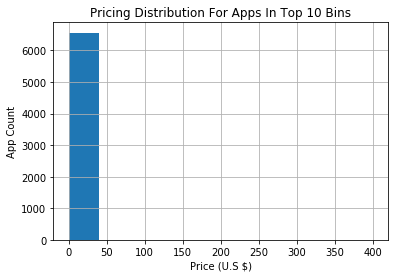

In [21]:
paid_apps = top_10_df["Price"]#top_10_df[top_10_df["Price"] > 0]
paid_apps.hist()
#paid_apps[paid_apps["Price"] < 20]["Price"].hist()
plt.title("Pricing Distribution For Apps In Top 10 Bins")
plt.ylabel("App Count")
plt.xlabel("Price (U.S $)")
plt.show()

This plot shows that paid apps in the top 10 bins mostly cost less than $50, but nothing else. How about seeing if there are outliers to this range? 

What interests me in finding out this answer is knowing what kind of apps cost more than $50 USD AND were downloaded over 50,000 times at least? They might either be something of high value to many users, or an outlier with a very interesting reason to land in the top 10 bins:

In [22]:
paid_apps = top_10_df[top_10_df["Price"] > 0]
paid_apps[paid_apps["Price"]>50]

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated,ReviewRatio
5356,I Am Rich Premium,FINANCE,4.1,1867,50000,Paid,399.99,Everyone,Finance,"November 12, 2017",0.03734
5351,I am rich,LIFESTYLE,3.8,3547,100000,Paid,399.99,Everyone,Lifestyle,"January 12, 2018",0.03547


After looking these apps up on their [Google Play page](https://play.google.com/store/apps/details?id=com.iamrich.diamondexpensive.i_am_rich&hl=en_US), it turns out their developer kept changing prices and the apps are there to show others you are rich, purposeless in my opinion!

Now I will get back to most paid apps and see how they range, this time limiting the price to something a little less than $40:

Text(0.5, 0, 'Price (U.S $)')

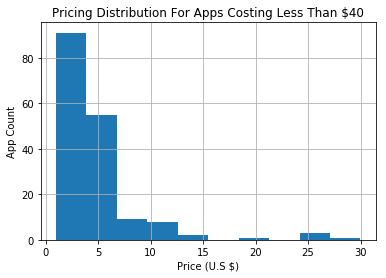

In [23]:
paid_apps[paid_apps["Price"]<40]["Price"].hist()
plt.title("Pricing Distribution For Apps Costing Less Than $40")
plt.ylabel("App Count")
plt.xlabel("Price (U.S $)")

Most apps cost less than \\$5 (or even \\$3, estimating through visuals). As would usually be expected, the amount of apps that cost more than that significantly decrease as we go up through the pricing, and a noticeable gap can be seen between about \\$16 to almost \\$23 for apps in the top 10 bins.

The competition in app development is at its top at the moment, with many alternatives developed to almost every app and are only based on human creativity plus the ability to code, lowering entry barriers for more competition. Therefore, pricing an app significantly higher than the market will certainly require significant, sustainable competitive advantage.

Finally, what is the minimum price for paid apps within the top 10 bins?

In [24]:
print("$ {}".format(paid_apps["Price"].min()))

$ 0.99


### C. Review Ratio

Our choice of only the top 10 bins is most suitable for exploring the ratio of reviews-to-installs, since apps in lower bins can be biased either by fake reviews, an individual developer's family and friends, or other factors. First, let's look at apps with review ratios where reviews surpass the amount of downloads:

In [25]:
top_10_df[top_10_df["ReviewRatio"] > 1]

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated,ReviewRatio


No apps in the top 10 bins have review ratios over 1, even though that could have been the case since a hypothetical app in the 50,000 bin could have actual amount of installs of 52,000 with 51,000 reviews, which in the case of bins is counted as 51,000 reviews over 50,000 (the bin amount, not the actual amount). However, that is clearly not the case in the real world as we have seen in this dataset.

Knowing that real-world reviews usually do not come close to the amount of installs, how does the distribution for the review ratio look like for the top 10 bins?

Text(0, 0.5, 'App Count')

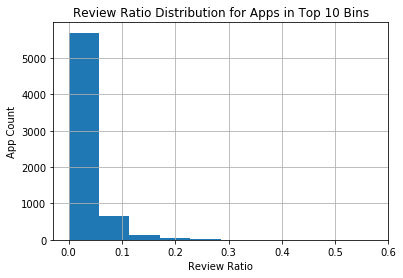

In [26]:
top_10_df["ReviewRatio"].hist()
plt.title("Review Ratio Distribution for Apps in Top 10 Bins")
plt.xlabel("Review Ratio")
plt.ylabel("App Count")

So, most review ratios are less than 0.1 of the amount of installs, and the highest of them seem to approach 0.3, all judged visually. Let's take a look at the actual numbers, this time using percentiles:

In [27]:
print("68th: {}".format(round(np.percentile(top_10_df["ReviewRatio"], 68),4)))
print("95th: {}".format(round(np.percentile(top_10_df["ReviewRatio"], 95),4)))
print("99th: {}".format(round(np.percentile(top_10_df["ReviewRatio"], 99),4)))
print("Max: {}".format(max(top_10_df["ReviewRatio"])))

68th: 0.0305
95th: 0.0972
99th: 0.1906
Max: 0.57076


The maximum point is a unique outlier, especially given the jump from 0.19 to 0.57, which is longer than the range for values below the 99th percentiles! For this purpose, let's explore the ratios depending on what we just found here:

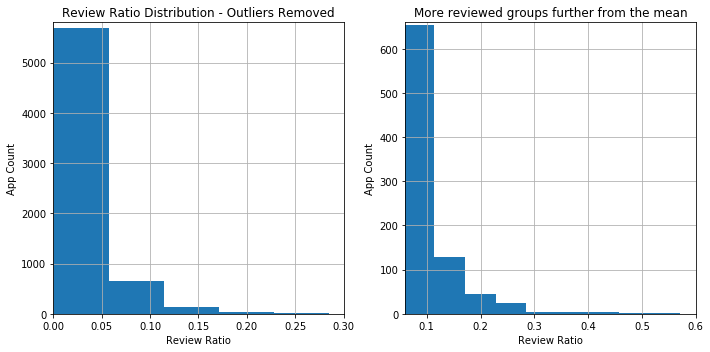

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
top_10_df["ReviewRatio"].hist()
plt.title("Review Ratio Distribution - Outliers Removed")
plt.xlabel("Review Ratio")
plt.ylabel("App Count")
plt.xlim(0,0.3)
plt.ylim(0,5800)

plt.subplot(1, 2, 2)
top_10_df["ReviewRatio"].hist()
plt.title("More reviewed groups further from the mean")
plt.xlabel("Review Ratio")
plt.ylabel("App Count")
plt.xlim(0.06,0.6)
plt.ylim(0,660)

plt.tight_layout()
plt.show()

The first plot shows most review ratios with only the maximum value removed, so it contains more than 99% of the data. We can see that most apps get reviewed 0.06 times as much as they get installed, while few apps get the opportunity to get reviewed 0.25 times their number of installs.

The second plot is there to zoom in on groups of fewer count but higher reveiw ratio. The first thing seen here is that the second plot almost looks strikingly similar to the first one, even though it clearly has different limitations for x and y ticks. Is there a correlation between the number of installs and the ratio of reviews?

In [29]:
top_10_df["ReviewRatio"].corr(top_10_df["Installs"])

-0.011941044038033975

This number does not indicate strong correlation. However, given huge numbers of installs and reviews for apps in the top 10 bins, this correlation seems to work into the review ratio, resulting in a recursively decreasing ratio of apps with more reviews.

## 3. Do people see paid apps in the same way they see free apps? 

In addition to the original dataset, the dataset creator also collected reviews for these apps and conducted a sentiment analysis using Python's nltk library, which I am lucky to have since it will be answering a very interesting question, *do people see paid apps in the same way they see free apps?*

To answer this question, I need to load the sentiment analysis data first:

In [30]:
sentiment_data = pd.read_csv("..\googleplaystore_user_reviews.csv")

#drop null values
sentiment_data = sentiment_data.dropna()
sentiment_data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


Good. Now we have a dataframe containing what we need on the side of sentiment analysis, but in order to compare free and paid apps, referred to here as the app type, we need to get these types from the dataframe we used above, app_data.

Some of the apps included in the sentiment_data dataframe are not in the app_data dataframe, and therefore will have their types returned as NaN, and will be removed once we add the new column. _**Note**: **This block of code will take a few seconds to run, due to the processing needed**_:

In [31]:
# A function to get the app type from the app_data dataframe and return it as a list
def get_app_type(col):
    type_list = []
    for value in col:
        try:
            a = app_data[app_data["App"]==value]["Type"].iloc[0]    
            type_list.append(a)
        except:
            type_list.append(np.nan)
    return type_list

# Call the get_app_type function on sentiment_data apps to get their app type & store it a new column
# Note this will take some time to execute given the large dataset
sentiment_data["Type"] = get_app_type(sentiment_data["App"])

#drop null values from sentiment data
sentiment_data = sentiment_data.dropna()

In [32]:
sentiment_data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Type
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,Free
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,Free
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,Free
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,Free
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,Free


Now that we have our dataframe containing the data we need to answer the analysis, let's see how many apps of each type we have:

In [33]:
#Generate counts of each unique values and print them
(values,counts)= np.unique(sentiment_data["Type"], return_counts=True)

for index in range(len(values)):
    print("{}: {}".format(values[index],counts[index]))

Free: 35513
Paid: 416


The sample size of free apps is close to 100 times the size of paid ones. This would give us the expectation that the statistics we are about to pull for free apps can be generalized of the population of free apps with more confidence than in the case of paid apps.

What I can do before comparing equal sample sizes is calculate the percentage of positive, neutral, and negative reviews for each dataset, which I will do right after creating their respective dataframes.

Now I will proceed to create new dataframes, one for free apps and another for paid ones. After that I will produce :

In [34]:
# A dataframe for each app type
free_apps = sentiment_data[sentiment_data["Type"]=="Free"]
paid_apps = sentiment_data[sentiment_data["Type"]=="Paid"]

In [35]:
print("Free Apps - Sentiment Percentage \n"+"-"*30+"\n{}\n\n".format(free_apps['Sentiment'].value_counts(normalize=True) * 100))
print("Paid Apps - Sentiment Percentage \n"+"-"*30+"\n{}".format(paid_apps['Sentiment'].value_counts(normalize=True) * 100))

Free Apps - Sentiment Percentage 
------------------------------
Positive    64.055416
Negative    22.363641
Neutral     13.580942
Name: Sentiment, dtype: float64


Paid Apps - Sentiment Percentage 
------------------------------
Positive    78.125000
Negative    15.144231
Neutral      6.730769
Name: Sentiment, dtype: float64


The percentage of positive sentiments in paid apps is higher than that of free apps. This can be due to several reasons, the most visible of which are that many paid apps have some kind of advantage that many free apps do not, such as providing a service that company x is known for, or executing a process based on proprietary technology. With that in mind, such apps usually have more support, including more frequent security and user interface updates, which results in higher user statisfaction. Another reason may be the notion of having invested an amount of money into this app, and therefore a user may reinforce their satisfaction with this investment by providing a positive review.

Again, the confidence in these percentages are higher for free apps than paid apps. If a paid apps sample of size equal to that of free apps was provided, the number may converge to a lower or a higher value.

When creating dataframes for each data type, indexes were moved along other data from the original dataframe, resulting in an index of unorganized integers. Due to the huge inequality of the count of free apps versus paid apps, I will be using index names to pick a random sample from free apps in order to perform head-to-head comparison. This calls for resetting the index for each of these dataframes:

In [36]:
#Reset index, then drop the old index column when it is moved to the right as a new column
paid_apps = paid_apps.reset_index().drop(columns=["index"])
free_apps = free_apps.reset_index().drop(columns=["index"])

#Generate a list of random indexes applicable to free_apps
random_indexes = np.random.choice(len(free_apps)-1, len(paid_apps), replace=False)

#Shorten free_apps to the same size of paid_apps & using a random selection
free_apps = free_apps.iloc[random_indexes]

#reset index of free_apps
free_apps = free_apps.reset_index().drop(columns=["index"])


len(free_apps)

416

Great, now we have two samples of equal size for both app types, which will allow for better comparison of sentiments. I move on to plotting counts of sentiments in each app type:

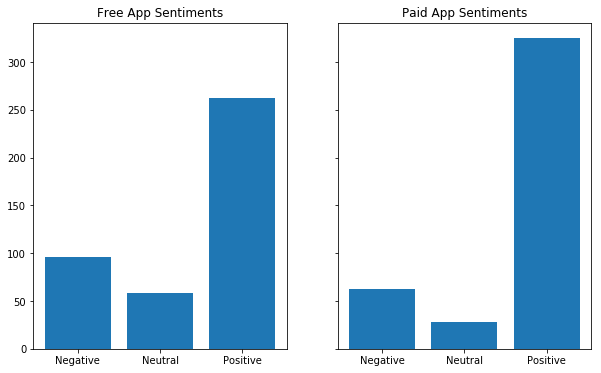

In [37]:
#Generate values & counts for Sentiment columns in our dataframes & put them in dictionaries
val_ct_free = np.unique(free_apps['Sentiment'],return_counts=True)
free_data = {value: count for value, count in zip(val_ct_free[0],val_ct_free[1])}

val_ct_paid = np.unique(paid_apps['Sentiment'],return_counts=True)
paid_data = {value: count for value, count in zip(val_ct_paid[0],val_ct_paid[1])}


#put values and counts each in a different variable for use in plots, taken from dictionaries
free_names = list(free_data.keys())
free_values = list(free_data.values())

paid_names = list(paid_data.keys())
paid_values = list(paid_data.values())


# Create a figure containing plots for each app type, sharing the y-axis for better comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 6),sharey=True)
axs[0].bar(free_names, free_values)
axs[0].set_title("Free App Sentiments")
axs[1].bar(paid_names, paid_values)
axs[1].set_title("Paid App Sentiments")
plt.show()



Even after we have taken an sample of free apps of equal size to paid apps, the plots show a higher number of positive sentiments for paid apps, and a slightly lower negative sentiment for paid apps. While neutral sentiments were higher for free apps, indicating higher variance of sentiments for free apps and higher polarity of sentiments for paid apps.

This subjects requires more clarification, which we will see in the next sections; polarity and subjectivity.

### 3.1. Sentiment Polarity

The polarity of a sentiment measures how negative or positive the context is, regardless of other factors. In the sentiment analysis data that we have, the polarity ranges from -1 (most negative) to +1 (most positive). In general, polarity can indicate whether people have strong opinions about a certain topic.

In our case, we can expect polarity to be more extreme towards either positive or negative opinions in the case of paid apps because a financial investment has been put in to obtain these apps. Let's find out by plotting polarity for both app types:

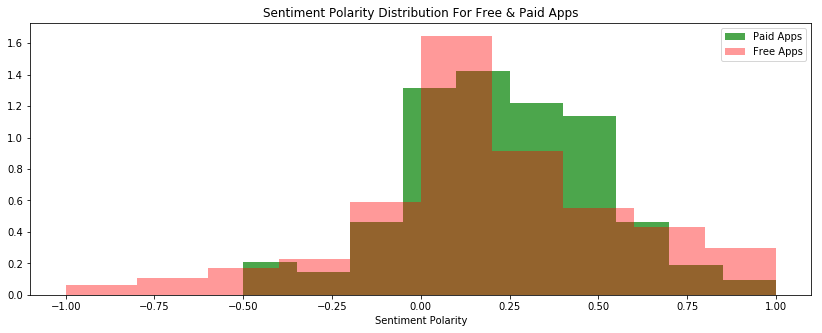

In [50]:
# Define variables that contain sentiment polarity for each app type
polarity_paid = paid_apps["Sentiment_Polarity"]
polarity_free = free_apps["Sentiment_Polarity"]

#Plot two histograms showing sentiment polarity of each app type
plt.figure(figsize=(14,5))
plt.hist(polarity_paid, normed=True, color="green",alpha=.7, label="Paid Apps") 
plt.hist(polarity_free, normed=True,color="red",alpha=.4, label="Free Apps")
plt.title('Sentiment Polarity Distribution For Free & Paid Apps')
plt.xlabel('Sentiment Polarity')
plt.legend(loc='upper right')
plt.show()

Seeing this plot, we can immediately notice more neutral polarity in free apps, seen through the larger red area right above the 0.00 on the x axis. However, there is also more extreme positive polarity for free apps, shown in the area from 0.5 to 1.00 on the x axis, the extremity is also evident for free apps in negative polarity from a little less than -0.75 to -0.50. The majority of sentiments for free apps is concentrated around neutral and mildly positive. Polarity of sentiments for free apps has more spread around 0.

As for paid apps, it seems like our assumption above does not stand when it comes to negative polarity of paid apps. Most sentiments are focused in between 0 and 0.5. Some sentiments do extend towards extremely positive, but none extend to below -0.5, indicating more general satisfaction with paid apps.

Let's take a look on solid numbers and see how these two samples compare:

In [39]:
print("Mean polarity of free apps : {}".format(round(polarity_free.mean(),3)))
print("Mean polarity of paid apps : {}".format(round(polarity_paid.mean(),3)))
print("Polarity std. deviation of free apps : {}".format(round(polarity_free.std(),3)))
print("Polarity std. deviation of paid apps : {}".format(round(polarity_paid.std(),3)))

Mean polarity of free apps : 0.178
Mean polarity of paid apps : 0.229
Polarity std. deviation of free apps : 0.384
Polarity std. deviation of paid apps : 0.272


The polarity mean difference between two samples is 0.047 within a range of 2 (from -1 to 1), which is considered a small difference. What is noticeable is the higher standard deviation for free apps, which is causing the wider spread of observations around their polarity mean. This is also the reason for paid app polarity observations being a bit more clustered around their mean.

Several reasons can provide justification for both **A.** having a higher standard deviation for polarity of free apps and **B.** paid app polarity being at a visible minimum of -0.5. One cause that jumps to mind and can justify both phenoma, is that free apps have looser terms and conditions for being published; an android developer can code an app in a relatively short time and put it on the market for free without having to have established real value for the app's user. On the other side, paid apps -who are able to compete in the Google Play store- are expected to have more robust value-producing technology within the app in order to convince the user of purchasing.

In [49]:
# Test similarity of samples with a t-value & a p-value
sample_comparison = list(ttest_ind(polarity_paid,polarity_free, equal_var=False))
sample_comparison = [round(value,2) for value in sample_comparison]
print("t-value: {}\np-value: {}".format(sample_comparison[0],sample_comparison[1]))

t-value: 2.17
p-value: 0.03


This t-value indicates there is some difference between sentiment polarity of free apps and polarity of paid apps. This difference is verified with a really small p-value of 0.03, which means that the same difference is most probably reflected in the the populations of paid and free apps.

In summary, this means that there is some difference in user's extremity of opinions towards paid and free apps, and that the sentiment polarity of reviews of each type of app is likely to follow the distribution of its respective histogram plotted above.

### 3.2. Sentiment Subjectivity

The subjectivitiy of a sentiment is how likely that sentiment is to be based on factual information, versus personal opinions or public notions. The lower the subjectivity, the more the sentiment is based on data or factual information. For this sentiment analysis, subjectivity values range from 0 (least subjective) to 1 (most subjective). 

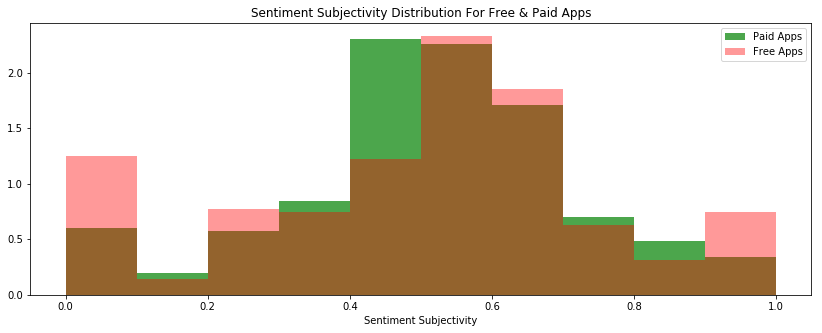

In [51]:
# Define variables that contain sentiment polarity for each app type
subjectivity_paid = paid_apps["Sentiment_Subjectivity"]
subjectivity_free = free_apps["Sentiment_Subjectivity"]

#Plot two histograms showing sentiment polarity of each app type
plt.figure(figsize=(14,5))
plt.hist(subjectivity_paid, normed=True, color="green",alpha=.7, label="Paid Apps") 
plt.hist(subjectivity_free, normed=True,color="red",alpha=.4, label="Free Apps")
plt.title('Sentiment Subjectivity Distribution For Free & Paid Apps')
plt.xlabel('Sentiment Subjectivity')
plt.legend(loc='upper right')
plt.show()

Both paid and free apps seem to have a distribution of sentiment subjectivity that is very close to a normal distribution, although paid apps have more data around the mean. The overall subjectivity of reviews of paid apps seem to be slightly lower than that of paid apps.

In [52]:
print("Mean subjectivity of free apps : {}".format(round(subjectivity_free.mean(),3)))
print("Mean subjectivity of paid apps : {}".format(round(subjectivity_paid.mean(),3)))
print("Subjectivity std. deviation of free apps : {}".format(round(subjectivity_free.std(),3)))
print("Subjectivity std. deviation of paid apps : {}".format(round(subjectivity_paid.std(),3)))

Mean subjectivity of free apps : 0.495
Mean subjectivity of paid apps : 0.511
Subjectivity std. deviation of free apps : 0.262
Subjectivity std. deviation of paid apps : 0.215


As can be expected from the histogram plot above, sentiment subjectivity in reviews for both types of apps is similar. The means of both samples are very close to each other, and the standard deviatons are also similar. User reviews are usually given based on a user's experience using the app, rather than being surveys about the app's design. The amount of users who are knowledgeable of app design and who can give reviews based on facts are the same, whether reviewing paid or free apps.

Let us validate our inference with a t-test:

In [53]:
# Test similarity of samples with a t-value & a p-value
sample_comparison = list(ttest_ind(subjectivity_paid,subjectivity_free, equal_var=False))
sample_comparison = [round(value,2) for value in sample_comparison]
print("t-value: {}\np-value: {}".format(sample_comparison[0],sample_comparison[1]))

t-value: 0.99
p-value: 0.32


The t-value of 0.99 says that the difference between the two sample is similar to the variance within each sample. In other words, it says that this difference found in paid apps, for example, is not unusual to find in free apps. That is because the difference is almost equal to the variance *within* paid apps, and therefore may expectedly be reproduced if we re-do the test using a different random sample from the free apps population.

The p-value of 0.32 indicates that this t-value is somewhat likely to have been caused by noise in the data rather than by actual difference in sentiment subjectivity towards either type of app.

## Conclusion